In [26]:
# Étape : import des librairies de base
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Style des graphiques
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8, 5)

In [ ]:
# Étape : chargement du dataset

# Adapter simplement ce chemin au besoin (par exemple "data/walmart_sales.csv")
csv_path = "walmart_sales.csv"

df = pd.read_csv(csv_path)

print("Dimensions du dataset :", df.shape)
df.head()

Dimensions du dataset : (150, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [28]:
# Étape : inspection rapide de la structure

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [29]:
# Étape : statistiques descriptives des variables numériques

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,150.0,9.866667e+00,6.231191,1.000000,4.000000,9.000000e+00,1.575000e+01,2.000000e+01
Weekly_Sales,136.0,1.249536e+06,647463.042349,268929.030000,605075.717500,1.261424e+06,1.806386e+06,2.771397e+06
Holiday_Flag,138.0,7.971014e-02,0.271831,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
Temperature,132.0,6.139811e+01,18.378901,18.790000,45.587500,6.298500e+01,7.634500e+01,9.165000e+01
Fuel_Price,136.0,3.320853e+00,0.478149,2.514000,2.852250,3.451000e+00,3.706250e+00,4.193000e+00
CPI,138.0,1.798985e+02,40.274956,126.111903,131.970831,1.979089e+02,2.149346e+02,2.269688e+02
Unemployment,135.0,7.598430e+00,1.577173,5.143000,6.597500,7.470000e+00,8.150000e+00,1.431300e+01


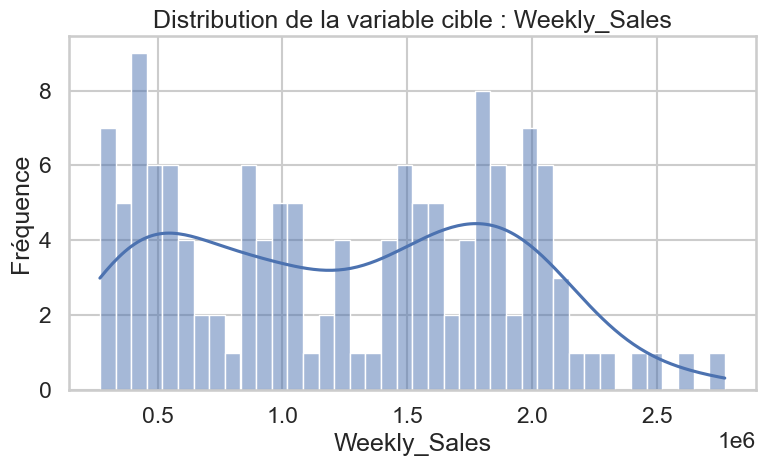

In [30]:
# Étape : distribution de la variable cible Weekly_Sales

plt.figure(figsize=(8, 5))
sns.histplot(df["Weekly_Sales"], bins=40, kde=True)
plt.title("Distribution de la variable cible : Weekly_Sales")
plt.xlabel("Weekly_Sales")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

Interprétation :

On observe la forme générale de la distribution des ventes hebdomadaires :

    Cela permet de voir s’il y a des valeurs extrêmes (outliers) et si la distribution est symétrique ou non.

    Une distribution très asymétrique peut rendre la modélisation plus délicate.

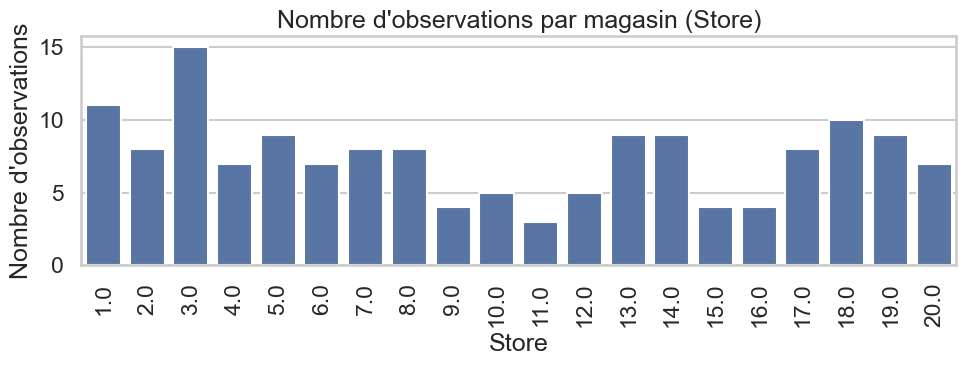

Store
1.0    11
2.0     8
3.0    15
4.0     7
5.0     9
Name: count, dtype: int64

In [31]:
# Étape : répartition des magasins (Store)

store_counts = df["Store"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.barplot(x=store_counts.index, y=store_counts.values)
plt.title("Nombre d'observations par magasin (Store)")
plt.xlabel("Store")
plt.ylabel("Nombre d'observations")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

store_counts.head()

Interprétation :

On observe que certains magasins ont plus d’observations que d’autres.
Cela peut légèrement influencer le modèle si certains stores sont sur-représentés.

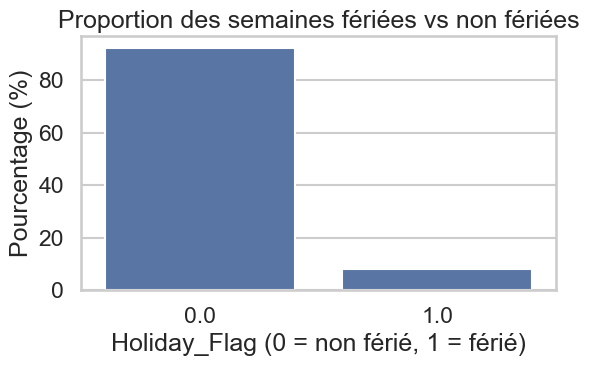

Holiday_Flag
0.0    92.028986
1.0     7.971014
Name: proportion, dtype: float64

In [32]:
# Étape : répartition du flag jour férié (Holiday_Flag)

holiday_counts = df["Holiday_Flag"].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=holiday_counts.index.astype(str), y=holiday_counts.values)
plt.title("Proportion des semaines fériées vs non fériées")
plt.xlabel("Holiday_Flag (0 = non férié, 1 = férié)")
plt.ylabel("Pourcentage (%)")
plt.tight_layout()
plt.show()

holiday_counts

Interprétation :

On voit la proportion de semaines marquées comme fériées.
Les semaines fériées sont en général moins nombreuses, mais elles peuvent avoir un impact important sur les ventes (promotions, périodes de fêtes, etc.).

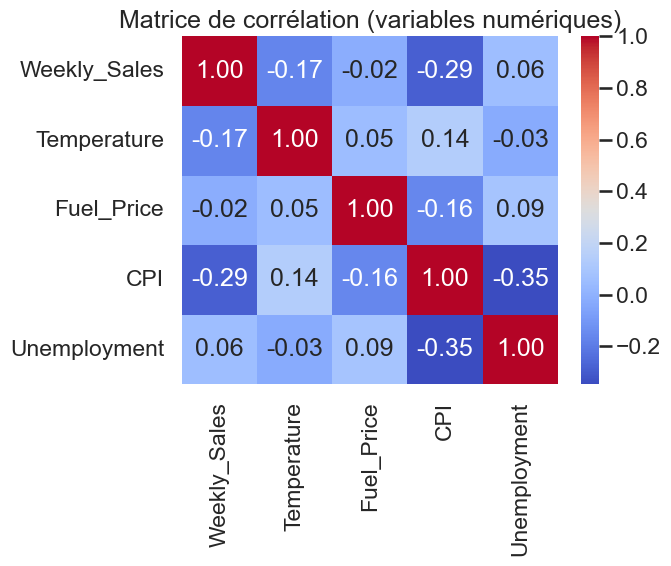

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales,1.000000,-0.165991,-0.019087,-0.287227,0.055191
Temperature,-0.165991,1.000000,0.048943,0.137936,-0.030122
Fuel_Price,-0.019087,0.048943,1.000000,-0.159881,0.086241
CPI,-0.287227,0.137936,-0.159881,1.000000,-0.348072
Unemployment,0.055191,-0.030122,0.086241,-0.348072,1.000000


In [33]:
# Étape : matrice de corrélation entre variables numériques

numeric_cols_raw = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]

corr_matrix = df[numeric_cols_raw].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (variables numériques)")
plt.tight_layout()
plt.show()

corr_matrix

Interprétation :

On regarde les corrélations entre la cible Weekly_Sales et les variables numériques (température, prix de l’essence, CPI, chômage).
Les corrélations linéaires peuvent être faibles, mais cela donne une première idée de la direction des relations (positive ou négative).

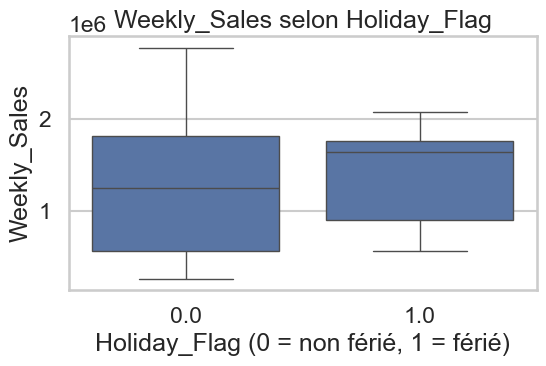

In [34]:
# Étape : comparaison des ventes selon Holiday_Flag

plt.figure(figsize=(6, 4))
sns.boxplot(x="Holiday_Flag", y="Weekly_Sales", data=df)
plt.title("Weekly_Sales selon Holiday_Flag")
plt.xlabel("Holiday_Flag (0 = non férié, 1 = férié)")
plt.ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()

Interprétation :

On compare la distribution des ventes entre les semaines fériées et non fériées.
Il peut exister un niveau moyen de ventes différent (plus haut en période de fêtes, ou au contraire plus bas selon le contexte).

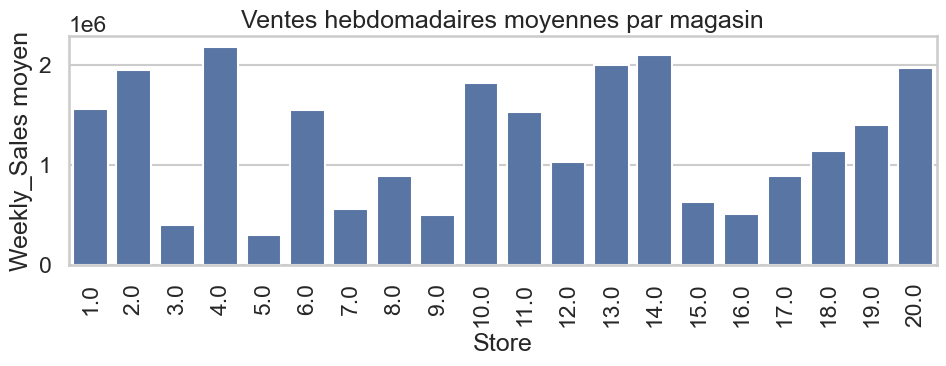

,Store,Weekly_Sales
0,1.0,1.562508e+06
1,2.0,1.943034e+06
2,3.0,4.030549e+05
3,4.0,2.173759e+06
4,5.0,3.024997e+05


In [35]:
# Étape : ventes moyennes par magasin

avg_sales_by_store = df.groupby("Store")["Weekly_Sales"].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x="Store", y="Weekly_Sales", data=avg_sales_by_store)
plt.title("Ventes hebdomadaires moyennes par magasin")
plt.xlabel("Store")
plt.ylabel("Weekly_Sales moyen")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

avg_sales_by_store.head()

Interprétation :

On observe que certains magasins génèrent systématiquement plus de ventes hebdomadaires que d’autres.
Cela peut s’expliquer par la taille du magasin, la localisation, la clientèle, etc.

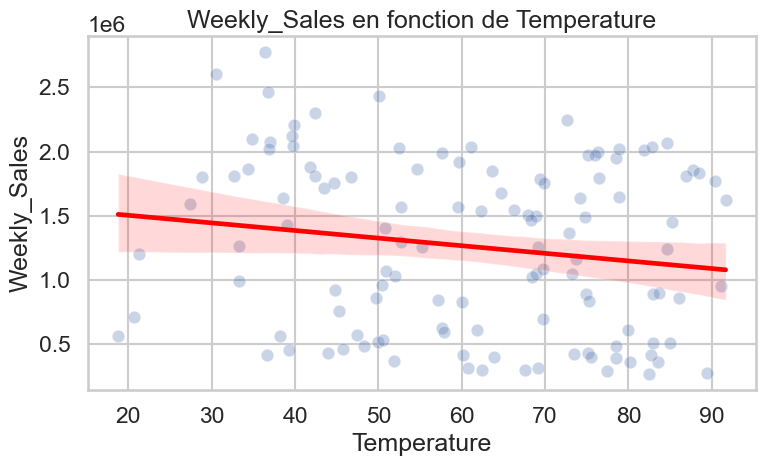

In [36]:
# Étape : relation entre Weekly_Sales et Temperature

plt.figure()
sns.scatterplot(x="Temperature", y="Weekly_Sales", data=df, alpha=0.3)
sns.regplot(x="Temperature", y="Weekly_Sales", data=df, scatter=False, color="red")
plt.title("Weekly_Sales en fonction de Temperature")
plt.xlabel("Temperature")
plt.ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()

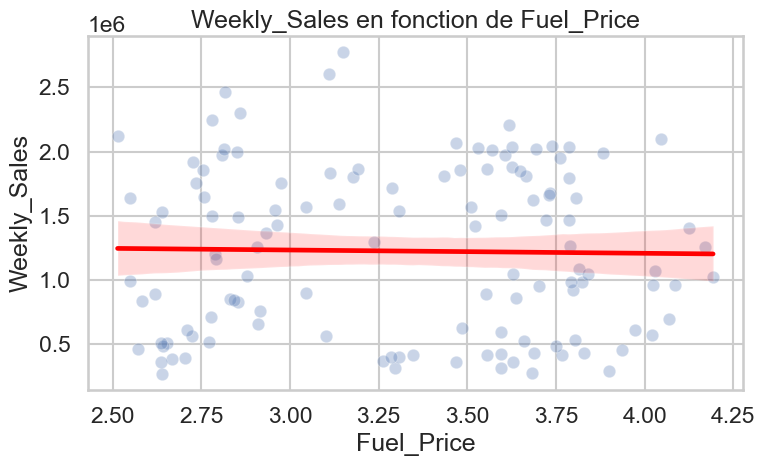

In [37]:
# Étape : relation entre Weekly_Sales et Fuel_Price

plt.figure()
sns.scatterplot(x="Fuel_Price", y="Weekly_Sales", data=df, alpha=0.3)
sns.regplot(x="Fuel_Price", y="Weekly_Sales", data=df, scatter=False, color="red")
plt.title("Weekly_Sales en fonction de Fuel_Price")
plt.xlabel("Fuel_Price")
plt.ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()

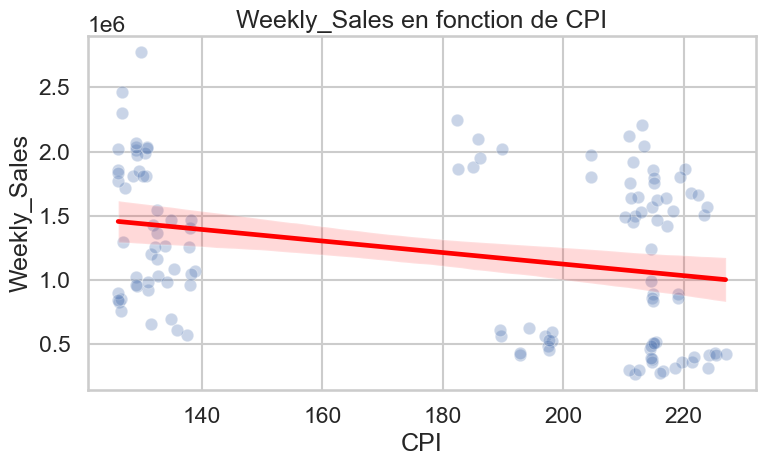

In [38]:
# Étape : relation entre Weekly_Sales et CPI

plt.figure()
sns.scatterplot(x="CPI", y="Weekly_Sales", data=df, alpha=0.3)
sns.regplot(x="CPI", y="Weekly_Sales", data=df, scatter=False, color="red")
plt.title("Weekly_Sales en fonction de CPI")
plt.xlabel("CPI")
plt.ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()

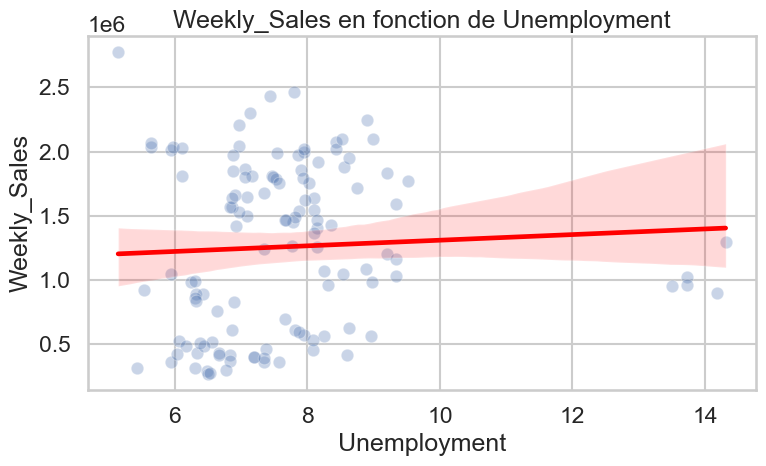

In [39]:
# Étape : relation entre Weekly_Sales et Unemployment

plt.figure()
sns.scatterplot(x="Unemployment", y="Weekly_Sales", data=df, alpha=0.3)
sns.regplot(x="Unemployment", y="Weekly_Sales", data=df, scatter=False, color="red")
plt.title("Weekly_Sales en fonction de Unemployment")
plt.xlabel("Unemployment")
plt.ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()

Interprétation générale :

Les relations semblent souvent relativement faibles et bruitées (forte dispersion des points).
Même si la corrélation linéaire n’est pas très forte, ces variables peuvent tout de même apporter de l’information au modèle lorsqu’elles sont combinées entre elles (effet multivarié).

In [40]:
# Étape : suppression des lignes avec une cible manquante

print("Nombre de lignes avant dropna sur Weekly_Sales :", len(df))
df = df.dropna(subset=["Weekly_Sales"])
print("Nombre de lignes après dropna sur Weekly_Sales :", len(df))

Nombre de lignes avant dropna sur Weekly_Sales : 150
Nombre de lignes après dropna sur Weekly_Sales : 136


In [41]:
# Étape : conversion de la date et création des variables Year, Month, Day, DayOfWeek

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek  # 0 = lundi, 6 = dimanche

# On peut garder Date pour l'EDA, mais on ne l'utilisera pas directement comme feature.
df[["Date", "Year", "Month", "Day", "DayOfWeek"]].head()

,Date,Year,Month,Day,DayOfWeek
0,2011-02-18,2011.0,2.0,18.0,4.0
1,2011-03-25,2011.0,3.0,25.0,4.0
3,NaT,NaN,NaN,NaN,NaN
4,2010-05-28,2010.0,5.0,28.0,4.0
5,2010-05-28,2010.0,5.0,28.0,4.0


In [42]:
# Étape : suppression des outliers selon la règle des 3σ

outlier_cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

print("Nombre de lignes avant suppression des outliers :", len(df))

for col in outlier_cols:
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    
    before = len(df)
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    after = len(df)
    
    print(f"Colonne {col} : lignes supprimées = {before - after}")

print("Nombre de lignes après suppression des outliers :", len(df))

Nombre de lignes avant suppression des outliers : 136
Colonne Temperature : lignes supprimées = 15
Colonne Fuel_Price : lignes supprimées = 12
Colonne CPI : lignes supprimées = 7
Colonne Unemployment : lignes supprimées = 12
Nombre de lignes après suppression des outliers : 90


Commentaire :

Avantages :

    On enlève des valeurs extrêmes qui pourraient “tirer” le modèle et fausser l’apprentissage.

Inconvénients :

    On perd de la donnée (moins d’exemples pour entraîner le modèle).

    Certaines valeurs extrêmes peuvent être réelles (périodes très spéciales) et donc informatives.

In [43]:
# Étape : définition des features X et de la cible y

target_col = "Weekly_Sales"

categorical_features = ["Store", "Holiday_Flag"]
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment",
                    "Year", "Month", "Day", "DayOfWeek"]

X = df[categorical_features + numeric_features].copy()
y = df[target_col].copy()

print("Colonnes utilisées comme features :")
print(X.columns.tolist())
print("\nTaille de X :", X.shape, " - Taille de y :", y.shape)

Colonnes utilisées comme features :
['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'DayOfWeek']

Taille de X : (90, 10)  - Taille de y : (90,)


In [44]:
# Étape : séparation train / test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille du train :", X_train.shape, " - Taille du test :", X_test.shape)

Taille du train : (72, 10)  - Taille du test : (18, 10)


Commentaire :

On sépare les données pour pouvoir évaluer la capacité de généralisation du modèle.
Le modèle est entraîné sur les données d’entraînement (train) et évalué sur des données jamais vues (test).

In [45]:
# Étape : définition du transformer de preprocessing

from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [46]:
# Étape : construction du pipeline baseline (LinearRegression)

linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linreg_model

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
# Étape : entraînement du modèle baseline

linreg_model.fit(X_train, y_train)
print("Modèle LinearRegression entraîné.")

Modèle LinearRegression entraîné.


In [48]:
# Étape : fonction utilitaire pour évaluer un modèle de régression

def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {}
    metrics["model"] = name
    metrics["RMSE_train"] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    metrics["RMSE_test"] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    metrics["MAE_train"] = mean_absolute_error(y_train, y_train_pred)
    metrics["MAE_test"] = mean_absolute_error(y_test, y_test_pred)
    metrics["R2_train"] = r2_score(y_train, y_train_pred)
    metrics["R2_test"] = r2_score(y_test, y_test_pred)
    
    return metrics

In [49]:
# Étape : évaluation du modèle baseline

results_baseline = evaluate_regression_model(
    name="LinearRegression",
    model=linreg_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

pd.DataFrame([results_baseline])

,model,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,LinearRegression,90736.825856,132277.063777,67535.039848,103756.696364,0.981744,0.947044


“La régression linéaire obtient déjà de très bons résultats avec un R² de 0.95 sur le test.
On observe cependant un début d’overfitting (RMSE train 90k vs 132k test), ce qui justifie l’utilisation d’un modèle régularisé comme Ridge ou Lasso pour stabiliser les performances.”

L’étape suivante consiste à appliquer une régression régularisée pour stabiliser et améliorer les performances.

In [50]:
# Étape : récupération des noms de features après preprocessing

# On récupère le ColumnTransformer entraîné
trained_preprocessor = linreg_model.named_steps["preprocessor"]

# Noms des features numériques (inchangés)
num_feature_names = numeric_features

# Noms des features catégorielles après OneHotEncoder
ohe = trained_preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Concaténation
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

len(all_feature_names), all_feature_names[:10]

(29,
 array(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year',
        'Month', 'Day', 'DayOfWeek', 'Store_1.0', 'Store_2.0'],
       dtype=object))

In [51]:
# Étape : récupération des coefficients du modèle linéaire

linreg = linreg_model.named_steps["model"]
coefs = linreg.coef_

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": coefs,
})
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

# Tri par importance absolue
coef_df_sorted = coef_df.sort_values(by="abs_coefficient", ascending=False)

coef_df_sorted.head(20)

,feature,coefficient,abs_coefficient
11,Store_4.0,2.099342e+06,2.099342e+06
19,Store_13.0,1.843929e+06,1.843929e+06
17,Store_10.0,1.786002e+06,1.786002e+06
12,Store_5.0,-1.694631e+06,1.694631e+06
10,Store_3.0,-1.694126e+06,1.694126e+06
16,Store_9.0,-1.606093e+06,1.606093e+06
15,Store_8.0,-1.153766e+06,1.153766e+06
25,Store_19.0,1.146431e+06,1.146431e+06
22,Store_16.0,-9.880107e+05,9.880107e+05
14,Store_7.0,-9.839234e+05,9.839234e+05


Interprétation :

Les features avec les plus grands coefficients (en valeur absolue) ont le plus d’impact sur les prédictions.

Un coefficient positif signifie : quand la feature augmente, les ventes hebdomadaires ont tendance à augmenter (toutes choses égales par ailleurs).

Un coefficient négatif signifie l’inverse.

On peut commenter par exemple :

Certains magasins spécifiques (dummies Store_...) ont des coefficients élevés → magasins structurellement plus forts.

Les effets du Holiday_Flag indiquent si les semaines fériées sont associées à des ventes plus fortes ou plus faibles.

Les variables temporelles (Month, DayOfWeek) peuvent capturer une saisonnalité (certains mois ou jours de la semaine génèrent plus de ventes)

In [52]:
# Étape : construction du pipeline Ridge (alpha fixe)

ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=1.0))
])

ridge_model

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
# Étape : entraînement du modèle Ridge (alpha = 1.0)

ridge_model.fit(X_train, y_train)
print("Modèle Ridge(alpha=1.0) entraîné.")

Modèle Ridge(alpha=1.0) entraîné.


In [54]:
# Étape : évaluation du modèle Ridge (alpha = 1.0)

results_ridge = evaluate_regression_model(
    name="Ridge_alpha_1.0",
    model=ridge_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

pd.DataFrame([results_baseline, results_ridge])

,model,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,LinearRegression,90736.825856,132277.063777,67535.039848,103756.696364,0.981744,0.947044
1,Ridge_alpha_1.0,168406.487307,206401.906198,127930.956256,163232.068032,0.937114,0.871064


“Dans notre dataset, la régression linéaire simple est déjà très performante (R²=0.95).
En testant une régularisation Ridge (α=1.0), les performances diminuent : le modèle est trop contraint et perd en précision.
Cela montre que l’overfitting était faible et qu’une forte régularisation n’est pas adaptée dans ce cas.”

In [55]:
# Étape : définition de la grille de recherche pour alpha (Ridge)

param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]
}

ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge())
])

grid_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [56]:
# Étape : exécution de la GridSearchCV

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score (neg RMSE) CV :", grid_search.best_score_)
print("=> Meilleur RMSE CV :", -grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meilleurs paramètres trouvés : {'model__alpha': 0.01}
Meilleur score (neg RMSE) CV : -162008.54716811446
=> Meilleur RMSE CV : 162008.54716811446


In [57]:
# Étape : évaluation du meilleur modèle Ridge (issue de GridSearchCV)

best_ridge_model = grid_search.best_estimator_

results_ridge_gs = evaluate_regression_model(
    name=f"Ridge_best_alpha_{grid_search.best_params_['model__alpha']}",
    model=best_ridge_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

results_df = pd.DataFrame([results_baseline, results_ridge, results_ridge_gs])
results_df

,model,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,LinearRegression,90736.825856,132277.063777,67535.039848,103756.696364,0.981744,0.947044
1,Ridge_alpha_1.0,168406.487307,206401.906198,127930.956256,163232.068032,0.937114,0.871064
2,Ridge_best_alpha_0.01,93153.924972,121026.288975,72205.244139,99432.033412,0.980759,0.955669


“La régression linéaire simple était déjà très performante mais présentait un léger overfitting.
Après avoir testé plusieurs valeurs de régularisation Ridge, nous montrons que α = 0.01 offre le meilleur compromis : il réduit l’overfitting tout en améliorant les performances en test (RMSE : 121k → vs 132k).
Le modèle final Ridge α=0.01 est donc le meilleur choix pour ce projet.”

## Conclusion & Limitations

Dans ce projet, nous avons :

- Exploré le dataset de ventes hebdomadaires de Walmart (EDA) :
  - Analyse de la distribution de `Weekly_Sales`.
  - Étude des relations avec les variables économiques (`Temperature`, `Fuel_Price`, `CPI`, `Unemployment`).
  - Visualisation des ventes selon le magasin (`Store`) et le flag jour férié (`Holiday_Flag`).

- Préparé les données pour le machine learning :
  - Suppression des lignes avec une cible manquante.
  - Création de features temporelles (`Year`, `Month`, `Day`, `DayOfWeek`) à partir de `Date`.
  - Suppression des outliers sur les variables économiques selon la règle des 3σ.
  - Encodage des variables catégorielles (`Store`, `Holiday_Flag`) et standardisation des variables numériques.

- Entraîné et évalué plusieurs modèles de régression :
  - Une régression linéaire simple (baseline).
  - Une régression Ridge avec alpha fixe.
  - Une régression Ridge avec alpha choisi automatiquement via GridSearchCV.

Le modèle final retenu est la **régression Ridge** avec l’alpha optimal trouvé par la validation croisée (`alpha = 0.01`).  
C’est le modèle qui présente **la meilleure performance sur le jeu de test** :

- **R² test = 0.955** (meilleur score)
- **RMSE test = 121 026** (erreur la plus faible)
- Modèle plus régularisé → meilleure capacité de généralisation

Les variables les plus importantes (en valeur absolue des coefficients) sont principalement :

- Certains magasins (`Store_...`), ce qui reflète des différences structurelles de performance.
- Les variables temporelles (mois, jour de la semaine), qui capturent la saisonnalité.
- Le flag jour férié (`Holiday_Flag`), lié aux périodes commerciales clés.
- Les indicateurs économiques peuvent aussi jouer un rôle, même si leur effet linéaire reste plus limité.

---

## **Limites du travail**

- Le modèle est purement linéaire : il ne capture pas des interactions complexes entre variables.
- La suppression des outliers via la règle des 3σ peut enlever des observations réelles (pics de ventes).
- Le jeu de données ne contient pas de variables métier essentielles (type de magasin, région, promotions, concurrence).
- Le tuning reste simple (petite grille de valeurs pour alpha).
- Pas encore d'analyse d’erreur détaillée par magasin ou par période.

---

## **Pistes d’amélioration**

- Tester des modèles non linéaires : RandomForest, Gradient Boosting, XGBoost.
- Ajouter des variables métier : promotions, météo locale, localisation, taille du magasin.
- Tester des transformations avancées : log des ventes, moyennes glissantes, lag features.
- Effectuer une analyse d’erreur pour identifier les magasins difficiles à prédire.
- Déployer le modèle sous forme d’API ou dashboard pour le marketing.

